# Unconstrained optimization
Unconstrained optimization refers to the set of problems, where we want to find the optimum (minimum or maximum) or a function over the entire variable space. More formally, this means we are trying to solve the following problem:
\begin{equation}
\begin{array}{ll}
\underset{x \in \mathscr{R}^n}{\text{minimize}} &f(x) \\
\end{array}
\end{equation}

The key question here is always whether $f(x)$ is convex or not. If it is convex, then you know that the local minimum is also a global minimum. However, if it is non-convex, then using local information is not enough, because there are multiple minima. Then you can still use gradient decent type methods, however you have to consider multiple starting points and/or build suitable convex hulls that allow you to "contain" the non-convexity.

> Stephen Boyd (famous for his [book](https://web.stanford.edu/~boyd/cvxbook/bv_cvxbook.pdf) on Convex Optimization and his lecture series at Standford, among other things) once explained the power of convexity very nicely: Convexity means that you something about the global state of the system from local information, e.g. the local gradient information points towards the global minimum of the function.

## How these problems are typically solved
Unconstrained optimization is a basically a solved problem, and when you have such a problem at hand you can expect to solve it in a short amount of time, even for large amount of variables. Having said that, there is still work being done in the area to bring down solution times especially considering their application in machine learning (e.g. check out the Adam [algorithm and paper](https://arxiv.org/abs/1412.6980)).

### If you know the function
If you know what $f(x)$ looks like, you can almost always simply chug it into `scipy` (as you will do below) and something useful will come out. If $f(x)$ is differentiable (i.e. the derivative exists and is well-defined), then you can use the derivative to drive the solution, which speeds up things dramatically (check out Wolfrahm's [derivative calculator](https://www.wolframalpha.com/calculators/derivative-calculator/) if you are a bit rusty on your chain rule). If $f(x)$ is twice differentiable, then you can even use Newton's method etc. directly without the need to compute the Hessian everytime anew. This may or may not make sense, as for (very) large problems some approximate Hessian matrix is much more easily computed than performing all the function evaluations.

### If you don't know the function
This is called blackbox optimization, and is typically quite hard. There are some tools for it, but much less refined than for the "whitebox" case. The way to approach this is to come up with a sampling technique of $x$, i.e. pick a value for $x$, evaluate $f(x)$, pick another $x$ etc. and then move into the direction that minimizes $f(x)$. If you know something about your problem, then you can use that. Otherwise I would suggest something along the lines of [Latin Hypercube sampling](https://en.wikipedia.org/wiki/Latin_hypercube_sampling) (or similar).

There are tools for this as well, for example from [COIN-OR](https://projects.coin-or.org/RBFOpt), [LocalSolver](https://www.localsolver.com/docs/last/advancedfeatures/blackbox.html) or [this stand-alone package](https://github.com/paulknysh/blackbox).

## How to use Python to solve unconstrained optimization problems
For solving unconstrained optimization problems, the `scipy` package is your best friend. Let's for example try to find the minimum of the following function:
\begin{equation}
f(x) = \cos(14.5x_0 - 0.3) + (x_1 + 0.2) x_1 + (x_0 + 0.2)x_0
\end{equation}

In [1]:
# Load the solver
from scipy import optimize
import numpy as np

# Define the objective and initial guess
func = lambda x: np.cos(14.5 * x[0] - 0.3) + (x[1] + 0.2) * x[1] + (x[0] + 0.2) * x[0]
x0 = [1.0, 1.0]

# Solve the problem and print result
ret = optimize.minimize(func, x0)
ret

      fun: 0.4159196810916892
 hess_inv: array([[ 4.74946972e-03, -7.72978880e-05],
       [-7.72978880e-05,  4.99760968e-01]])
      jac: array([1.49011612e-06, 5.21540642e-08])
  message: 'Optimization terminated successfully.'
     nfev: 40
      nit: 6
     njev: 10
   status: 0
  success: True
        x: array([ 1.09260107, -0.09999998])

So in essence, you simply have to define your function, call into `optimize` and off you go. While it is this simple for most cases, there are a couple of parameters to be aware of in case things get a bit iffy (or you need a performance increase etc.).
1. Choice of algorithm: `scipy` offers you a bunch of algorithms to choose from, and a priori it is going to be very hard to know which one works best (although with some experience you can probably say which one won't work). This can be done by simply adding the parameter `method` to the `minimzize` call (see [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) for a list of available methods):

In [2]:
optimize.minimize(func, x0, method='nelder-mead')

 final_simplex: (array([[ 1.09260638, -0.10000084],
       [ 1.09259201, -0.10002175],
       [ 1.09260596, -0.0999185 ]]), array([0.41591968, 0.41591969, 0.41591969]))
           fun: 0.4159196840441879
       message: 'Optimization terminated successfully.'
          nfev: 89
           nit: 47
        status: 0
       success: True
             x: array([ 1.09260638, -0.10000084])

2. Termination criterion: the most common termination criterion is the relative tolerance, i.e. the relative (meaning in %) improvement of the newest solution to the previous solution. Alternatively, it is also common to have "$n$ iterations without an improvement", especially for nonconvex problems. However, if you have time constraints, it may be ok to terminate after $n$ iterations, regardless of what's the result. As these options are solver-specific, check the list [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.show_options.html#scipy.optimize.show_options).

In [3]:
optimize.minimize(func, x0, method='nelder-mead', options={'maxiter': 10})

 final_simplex: (array([[1.125, 0.7  ],
       [1.075, 0.75 ],
       [1.125, 0.75 ]]), array([1.16663903, 1.17022506, 1.24913903]))
           fun: 1.1666390335898562
       message: 'Maximum number of iterations has been exceeded.'
          nfev: 20
           nit: 10
        status: 2
       success: False
             x: array([1.125, 0.7  ])

3. Step-size: all of these methods rely in some shape or form on moving from $x_k$ to $x_{k+1}$ by means of a step-size parameter. This parameter is calculated by using line search or trust regions, and so you cannot really tune it. But especially if you implement your own solver, or try to inject something into the solver if you have special knowledge of the problem, this is a screw you can turn.
4. Scaling: This will be a recurring theme in the other parts as well: all numerical methods rely on the fact that the various inputs are sensibly scaled against each other. If you have in your matrix an index of $10^8$ and $10^{-4}$ at the same time, the optimizer will have a hard time finding the true optimium as it operates on finite machine precision.

## Your tasks
Now it's your turn. Consider the following nonlinear spring system:

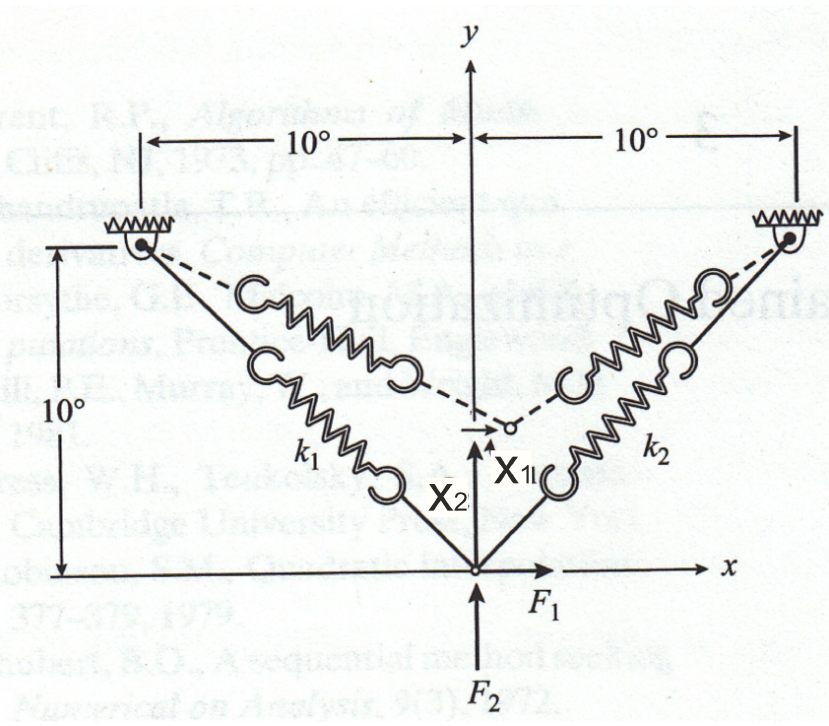

The applied forces here are $F_1 = 0$ and $F_2 = 2N$ and the spring constants are $k_1 = k_2 = 1 N/m$ [$N$ is the unit "Newton"]. There is a shift in the $x$ and $y$ direction of the junction of the two springs due to the applied forces. What are the values of these shifts? Note: the shifts are given by the place, where the potential energy is minimal.

The potential energy is given by:
\begin{equation}
P(x,y) = \frac{1}{2} k_1(\Delta L_1)^2 + \frac{1}{2}k_2(\Delta L_2)^2 - F_1x - F_2y
\end{equation}
where $\Delta L_1$ and $\Delta L_2$ are the changes in the length of the springs, given by:
\begin{align}
\Delta L_1 &= \sqrt{(x + 10)^2 + (y - 10)^2} - 10\sqrt{2} \\
\Delta L_2 &= \sqrt{(x - 10)^2 + (y + 10)^2} - 10\sqrt{2}
\end{align}


Your tasks are divided into two parts.
1. What are the shifts of the springs?
2. What is the performance difference between the different solvers, that do not require a Jacobian [a list is given below here:]

In [4]:
methods = ['Nelder-Mead', 'Powell', 'CG', 'BFGS', 'L-BFGS-B', 'TNC', 'COBYLA', 'SLSQP']